In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from functools import reduce, lru_cache
import datetime
import pickle

def data_extend(data, k):
    r, c = data.shape
    data_extend = (reduce(lambda x, y: np.vstack((x, y)),
                          map(lambda x: data, range(k))) +
                  np.random.randn(r*c*k).reshape(r*k, c).round(1))
    return(data_extend)

def hac(k, data):
    n = data.shape[0]
    
    # start with each point in its own cluster
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    
    while unique_clusters > k:
        min_distances = np.zeros(n)
        min_points = np.zeros(n).astype('int')

        # for each point, find min distance to point not in cluster
        for i in range(n):
            point = data[i,]
            point_cluster = clusters[i]
            distances = np.linalg.norm(point - data, axis = 1)
            diff_cluster_points = np.where(
                clusters != point_cluster)[0]

            min_points[i] = diff_cluster_points[
                np.argmin(distances[diff_cluster_points])]
            min_distances[i] = distances[min_points[i]]

        # merge clusters of the two closest points
        point1_idx = np.argmin(min_distances)
        point1 = data[point1_idx,]
        point2_idx = min_points[point1_idx]
        point2 = data[point2_idx,]

        point2_cluster = clusters[point2_idx]
        clusters[np.where(
            clusters == point2_cluster
        )[0]] = clusters[point1_idx]

        # update number of clusters
        unique_clusters = len(np.unique(clusters))
    
    return clusters

@lru_cache(maxsize=None)
def unary(x, C):
    nearest_x = int(np.round(x))
    return(np.r_[np.ones(nearest_x), np.zeros(C-nearest_x)])

@lru_cache(maxsize=None)
def lsh_hash(point, C):
    point = np.array(point)
    res = np.concatenate(list(map(lambda x: unary(x, C), point)))
    return(res)

@lru_cache(maxsize=None)
def get_points_in_cluster(idx, clusters, data):
    clusters = np.array(clusters)
    data = pickle.loads(data)
    point_cluster = clusters[idx]
    same_cluster_points_idx = np.where(
        clusters == point_cluster)[0]
    same_cluster_points = set(
        map(tuple, data[same_cluster_points_idx, :])
    )
    return(same_cluster_points)

@lru_cache(maxsize=None)
def get_point_indices(data, points):
    data = pickle.loads(data)
    points = pickle.loads(points)
    indices = np.where((data == points[:,None]).all(-1))[1]
    return(indices)

def clear_caches():
    unary.cache_clear()
    lsh_hash.cache_clear()
    get_points_in_cluster.cache_clear()
    get_point_indices.cache_clear()

def build_hash_tables(C, d, l, k, data, clusters):
    vals = np.arange(C*d)
    n = data.shape[0]
    hash_tables = defaultdict(set)
    hash_tables_reversed = defaultdict(set)

    for i in range(l):
        I = np.random.choice(vals, k, replace = False)

        for j in range(n):
            # for every point, generate hashed point
            # and sample k bits
            p = data[j]
            hashed_point = lsh_hash(tuple(p), C)[I]
            
            # check if any other points in p's cluster are
            # already in this hash table and only add point to
            # hash table if no other points from its cluster are there
            bucket = hash_tables[tuple(hashed_point)]
            cluster_points = get_points_in_cluster(
                j, tuple(clusters), pickle.dumps(data)
            )
            
            # create unique bucket for each hash function
            #key = tuple([i]) + tuple(hashed_point)

            if not cluster_points.intersection(bucket):
                hash_tables[tuple(hashed_point)].add(tuple(p))
                hash_tables_reversed[tuple(p)].add(tuple(hashed_point))
    
    return hash_tables, hash_tables_reversed

def LSHLink(data, A, l, k, C = None, cutoff = 1, dendrogram = False, **kwargs):
    # set default value for C if none is provided
    if not C:
        C = int(np.ceil(np.max(data))) + 1
    
    if dendrogram and cutoff != 1:
        raise Exception(
            'Dendrogram requires a full hierarchy; set cutoff to 1'
        )
    
    # initializations
    n, d = data.shape
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    num = n - 1
    Z = np.zeros((n - 1, 4))
    
    # calculate r depending on n, either:
    # 1. min dist from a random sample of sqrt(n) points
    # 2. formula below
    
#     if 'seed1' in kwargs and isinstance(kwargs['seed1'], int):
#         np.random.seed(kwargs['seed1'])
    np.random.seed(12)
        
    n_samp = int(np.ceil(np.sqrt(n)))
    samples = data[
        np.random.choice(n, size = n_samp, replace = False), :]
    
    if n < 500:
        r = np.min(pdist(samples, 'euclidean'))
    else:
        r = (d * C * np.sqrt(d)) / (2 * (k + d))
    
#     if 'seed2' in kwargs and isinstance(kwargs['seed2'], int):
#         np.random.seed([kwargs['seed2']])
    np.random.seed(6)

    while unique_clusters > cutoff:
        # STEP 1: Generation of hash tables
        hash_tables, hash_tables_reversed = build_hash_tables(
            C, d, l, k, data, clusters)

        # STEP 2: Nearest neighbor search for p
        for i in range(n):
            # get all of those hash tables that contain point p
            p = data[i]
            p_hashes = hash_tables_reversed[tuple(p)]

            # only proceed if p is in at least one hash table
            if hash_tables_reversed[tuple(p)]:

                # find all "similar points" to p: points that share
                # at least one hash table with p, and are not in the
                # same cluster as p
                similar_points = reduce(
                    lambda x, y: x.union(y),
                    map(lambda x: hash_tables[x], p_hashes)
                    ).difference(
                    get_points_in_cluster(i, tuple(clusters),
                                          pickle.dumps(data))
                )
                similar_points = np.array(list(similar_points))

                # STEP 3: Connect pairs of clusters within certain
                # distance of p
                # only proceed if p has any similar points
                if similar_points.size:

                    # find similar points q s.t. dist(p, q) < r
                    # the clusters containing these points will be
                    # merged with p's cluster
                    points_to_merge = similar_points[
                        np.where(
                            np.linalg.norm(p - similar_points, axis = 1) < r
                        )[0]
                    ]

                    # only proceed if p has similar points within distance r
                    if points_to_merge.size:
                        # identify which clusters contain points_to_merge
                        point_indices = get_point_indices(
                            pickle.dumps(data),
                            pickle.dumps(points_to_merge)
                        )
                        clusters_to_merge = list(
                            np.unique(clusters[point_indices])
                        )
                        
                        # update cluster labels
                        # if dendrogram = False, we can use a simpler method
                        if not dendrogram:
                            clusters[
                                np.where(np.in1d(clusters, clusters_to_merge)
                                        )[0]] = clusters[i]
                        
                        else:
                            clusters_to_merge.append(clusters[i])
                            
                            for j in range(len(clusters_to_merge) - 1):
                                clusterA = clusters_to_merge[j]
                                clusterB = clusters_to_merge[j+1]
                                num += 1
                                clusters[np.where(
                                    np.in1d(clusters, [clusterA, clusterB])
                                )[0]] = num

                                Z[num - n, :] = np.array(
                                    [clusterA,
                                     clusterB,
                                     r,
                                     len(np.where(np.in1d(clusters, num))[0])]
                                )
                                clusters_to_merge[j:j+2] = 2 * [num]

        # STEP 4: update parameters and continue until
        # unique_clusters == cutoff
        unique_clusters = len(np.unique(clusters))

        #increase r and decrease k
        r *= A
        k = int(np.round((d * C * np.sqrt(d)) / (2 * r)))

    if not dendrogram:
        return(clusters)
    
    else:
        return(clusters, Z)

In [57]:
iris = datasets.load_iris().data
iris = data_extend(iris, 67) * 10
iris += np.abs(np.min(iris))

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

In [58]:
iris.shape

(10050, 4)

In [59]:
clear_caches()

In [ ]:
##### A = 1.4

In [65]:
# n = 150
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

460 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [69]:
# n = 450
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

2.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [73]:
# n = 1050
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

12.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [79]:
# n = 1500
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

20 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [85]:
# n = 1950
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

37.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [89]:
# n = 2550
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

56.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
# n = 3000
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100)

1min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
##### A = 2.0

In [6]:
# n = 150
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

285 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
# n = 450
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

1.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
# n = 1050
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

7.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
# n = 1500
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
# n = 1950
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

21.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [25]:
# n = 2550
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

36.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [29]:
# n = 3000
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

58.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [60]:
# n = 10050
%timeit -r1 LSHLink(iris, A = 2.0, l = 10, k = 100)

KeyboardInterrupt: 

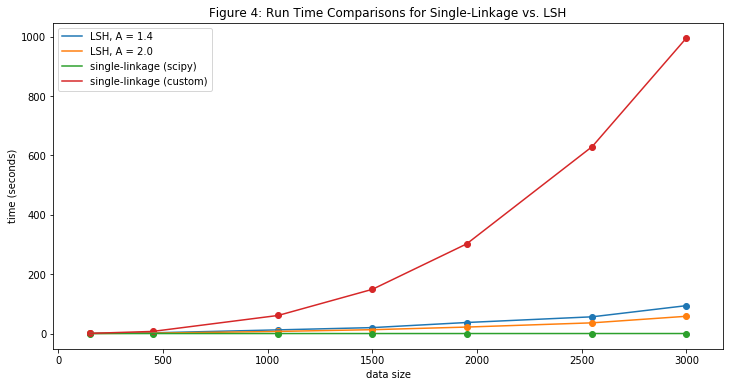

In [56]:
lsh_A14_y = [.46, 2.37, 12.4, 20, 37.2, 56.4, 94]
lsh_A14_x = [150, 450, 1050, 1500, 1950, 2550, 3000]

lsh_A20_x = [150, 450, 1050, 1500, 1950, 2550, 3000]
lsh_A20_y = [.285, 1.31, 7.15, 13, 21.8, 36.1, 58.2]

sci_x = [150, 450, 1050, 1500, 1950, 2550, 3000]
sci_y = [0.000215, 0.00136, 0.00996, 0.0187, 0.0341, 0.0592, 0.0843]

single_x = [150, 450, 1050, 1500, 1950, 2550, 3000]
single_y = [0.530, 7.13, 61, 149, 302, 630, 996]

plt.scatter(lsh_A14_x, lsh_A14_y)
plt.plot(lsh_A14_x, lsh_A14_y, label = 'LSH, A = 1.4')
plt.scatter(lsh_A20_x, lsh_A20_y)
plt.plot(lsh_A20_x, lsh_A20_y, label = 'LSH, A = 2.0')
plt.scatter(sci_x, sci_y)
plt.plot(sci_x, sci_y, label = 'single-linkage (scipy)')
plt.scatter(single_x, single_y)
plt.plot(single_x, single_y, label = 'single-linkage (custom)')
plt.legend(loc = 'upper left')
plt.xlabel('data size')
plt.ylabel('time (seconds)')
plt.title('Figure 4: Run Time Comparisons for Single-Linkage vs. LSH')
plt.gcf().set_size_inches(12, 6)
plt.show();

In [37]:
iris = datasets.load_iris().data
iris = data_extend(iris, 1) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(150, 4)
215 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
530 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [38]:
iris = datasets.load_iris().data
iris = data_extend(iris, 3) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(450, 4)
1.36 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
7.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
iris = datasets.load_iris().data
iris = data_extend(iris, 7) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(1050, 4)
9.96 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
iris = datasets.load_iris().data
iris = data_extend(iris, 10) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(1500, 4)
18.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2min 29s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [41]:
iris = datasets.load_iris().data
iris = data_extend(iris, 13) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(1950, 4)
34.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
5min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [42]:
iris = datasets.load_iris().data
iris = data_extend(iris, 17) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(2550, 4)
59.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
10min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [43]:
iris = datasets.load_iris().data
iris = data_extend(iris, 20) * 10
iris += np.abs(np.min(iris))
print(iris.shape)

l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

%timeit -r1 linkage(iris, method = 'single')
%timeit -r1 hac(1, iris)

(3000, 4)
84.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
16min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
